In [2]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
import os
from shutil import copyfile
import time
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# dimensions of our images.
img_width, img_height = 150, 150

top_model_weights_path = 'bottleneck_fc_model.h5'
bottleneck_dir = '/data/nacti/initial_set/bottlenecks'
train_bottlenecks = os.path.join(bottleneck_dir, 'bottleneck_features_train.npy')
validation_bottlenecks = os.path.join(bottleneck_dir, 'bottleneck_features_validation.npy')
train_data_dir = '/data/nacti/initial_set/train'
validation_data_dir = '/data/nacti/initial_set/validation'
nb_train_samples = sum([len(f) for r, d, f in os.walk(train_data_dir)])
nb_validation_samples = sum([len(f) for r, d, f in os.walk(validation_data_dir)])
epochs = 15
bottleneck_batch_size = 1
train_batch_size = 16

In [7]:
def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the ResNet50 network
    model = applications.ResNet50(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples//batch_size)
    np.save(open(train_bottlenecks, 'wb'),
        bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples//batch_size)
    np.save(open(validation_bottlenecks, 'wb'),
        bottleneck_features_validation)
    
def build_labels_from_directory(directory):
    labels = []
    for i, (r, s, f) in enumerate(os.walk(directory)):
        labels += [i-1]*len(f)
        
    return to_categorical(np.array(labels))
    
def train_top_model():
    train_data = np.load(train_bottlenecks)
    train_labels = build_labels_from_directory(train_data_dir)

    validation_data = np.load(validation_bottlenecks)
    validation_labels = build_labels_from_directory(validation_data_dir)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(15, activation='softmax'))

    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=train_batch_size,
              validation_data=(validation_data, validation_labels))
    model.save_weights(top_model_weights_path)

In [7]:
np.load(train_bottlenecks).shape

(8087, 5, 5, 2048)

In [8]:
np.load(validation_bottlenecks).shape

(2714, 5, 5, 2048)

In [4]:
train_top_model()

Train on 8087 samples, validate on 2714 samples
Epoch 1/15
8087/8087 [==============================] - 45s 6ms/step - loss: 2.8241 - acc: 0.1016 - val_loss: 2.4442 - val_acc: 0.1080
Epoch 2/15
8087/8087 [==============================] - 41s 5ms/step - loss: 2.4486 - acc: 0.1364 - val_loss: 2.3311 - val_acc: 0.1839
Epoch 3/15
8087/8087 [==============================] - 41s 5ms/step - loss: 2.3917 - acc: 0.1549 - val_loss: 2.3402 - val_acc: 0.1389
Epoch 4/15
8087/8087 [==============================] - 41s 5ms/step - loss: 2.3693 - acc: 0.1653 - val_loss: 2.3566 - val_acc: 0.1713
Epoch 5/15
8087/8087 [==============================] - 41s 5ms/step - loss: 2.3507 - acc: 0.1580 - val_loss: 2.5174 - val_acc: 0.1323
Epoch 6/15
8087/8087 [==============================] - 41s 5ms/step - loss: 2.3447 - acc: 0.1658 - val_loss: 2.2544 - val_acc: 0.2100
Epoch 7/15
8087/8087 [==============================] - 40s 5ms/step - loss: 2.3381 - acc: 0.1636 - val_loss: 2.2229 - val_acc: 0.2155
Epoch 8

In [3]:
model = Sequential()
model.add(Flatten(input_shape=(5,5,2048)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(15, activation='softmax'))
model.load_weights('/data/nacti/initial_set/bottleneck_fc_model.h5')

In [8]:
preds = np.argmax(model.predict(np.load(validation_bottlenecks)), axis=1)
labels = np.argmax(build_labels_from_directory(validation_data_dir), axis=1)

In [9]:
sum(labels == preds)/len(labels)

0.2184966838614591

In [10]:
print(confusion_matrix(labels, preds))

[[  8  91   1   0   0   0   0   0   0   0   0   0   1 118  32]
 [ 23 153   0   0   0   0   0   0   0   0   0   0   0  32  43]
 [  1   2 182   0   0   0   0   0   0   0   0   0   8  33   0]
 [  0   0  74   0   0   0   0   0   0   0   0   0   7 165   5]
 [  0   0   4   0   0   0   0   0   0   0   0   0   3  29   0]
 [  3   2  34   0   0   0   0   0   0   0   0   0  11 195   6]
 [  9  32  70   0   0   0   0   0   0   0   0   0   5 113  22]
 [  0   0  24   0   0   0   0   0   0   0   0   0   0   3   0]
 [  0   0 107   0   0   0   0   0   0   0   0   0   4  12   0]
 [  0   0  33   0   0   0   0   0   0   0   0   0   2  61   0]
 [  1   0  14   0   0   0   0   0   0   0   0   0   9 144   3]
 [  0   0  14   0   0   0   0   0   0   0   0   0   2  10   1]
 [  0   0 137   0   0   0   0   0   0   0   0   0   8 106   0]
 [  3  11   1   0   0   0   0   0   0   0   0   0   2 223  11]
 [ 17  84   3   0   0   0   0   0   0   0   0   0   6 122  19]]


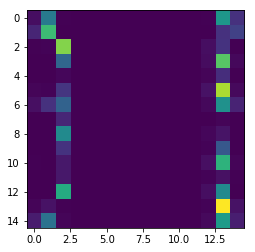

In [13]:
plt.imshow(confusion_matrix(labels, preds))